In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from scipy.stats import binned_statistic

In [2]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [3]:
g = GaiaData('../data/gd1-master.fits')
stream = g[g.pm_mask & g.gi_cmd_mask]

In [4]:
phi1 = stream.phi1
phi2 = stream.phi2
pm1 = stream.pm_phi1_cosphi2
pm2 = stream.pm_phi2

## Define track selection

In [5]:
ptrack = np.load('../output/polytrack.npy')
polytrack = np.poly1d(ptrack)

In [6]:
pred_phi2 = polytrack(g.phi1.value)
phi2_plus = 1.8
phi2_minus = 1.5
track_mask = ((g.phi2.value < (pred_phi2 + phi2_plus)) & 
              (g.phi2.value > (pred_phi2 - phi2_minus)) &
              (g.phi1.value > -90) & (g.phi1.value < 10))
track_mask.sum()

733462

In [7]:
# if 'stream_track_mask' not in g.data.colnames:
#     g.data['stream_track_mask'] = track_mask
#     g.data.write('../data/gd1-with-masks.fits', overwrite=True)

In [8]:
full_mask = g.pm_mask & g.gi_cmd_mask & track_mask
full_mask.sum()

1985

In [9]:
ptstyle = dict(color='k', marker='o', linewidth=0, 
               markersize=2, alpha=0.6, rasterized=True, linestyle='none')

(-10, 5)

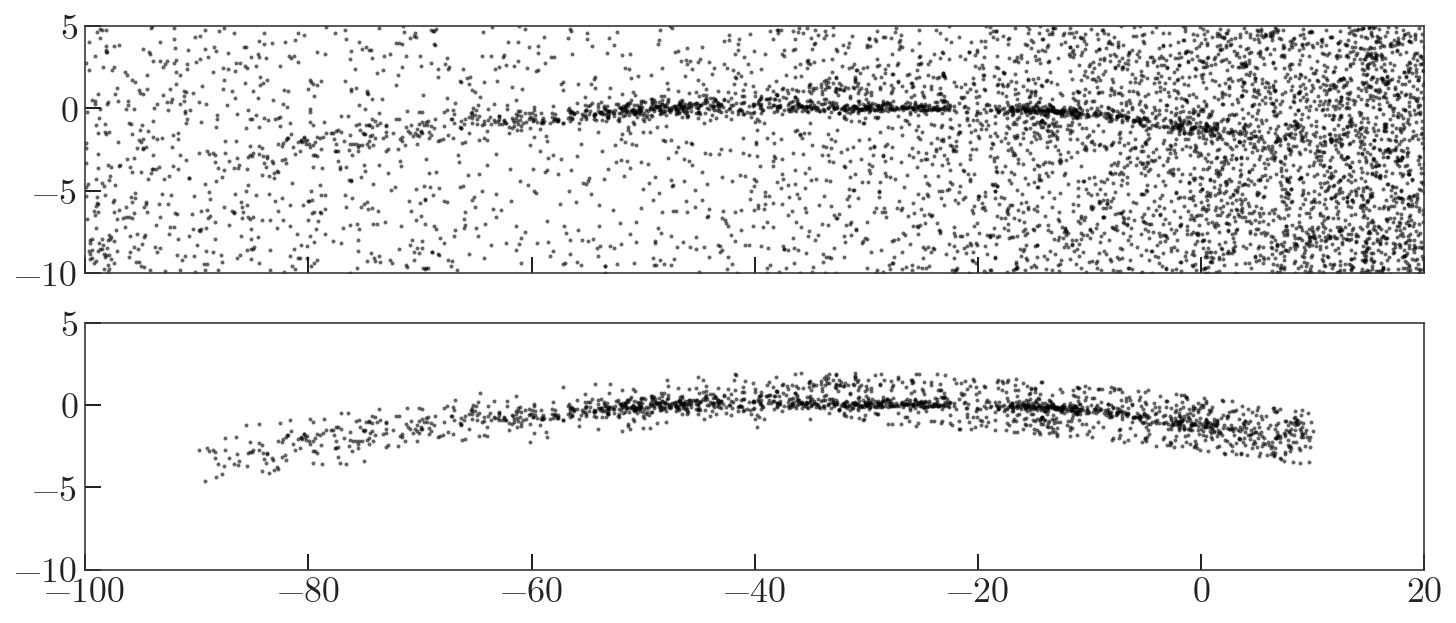

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

axes[0].plot(g.phi1[g.pm_mask & g.gi_cmd_mask], g.phi2[g.pm_mask & g.gi_cmd_mask], **ptstyle)
axes[1].plot(g.phi1[full_mask], g.phi2[full_mask], **ptstyle)
axes[0].set_xlim(-100, 20)
axes[0].set_ylim(-10, 5)

In [11]:
track = Table.read('../output/stream_track.fits')

In [12]:
bin_size = 4. # see 3-stream-track
bin_l = track['phi1'] - bin_size/2
bin_r = track['phi1'] + bin_size/2

In [13]:
stream_w1 = np.load('../output/stream_model_-13.5.npy')
stream_w2 = np.load('../output/stream_model_-20.0.npy')

streams = []
for stream_w in [stream_w1, stream_w2]:
    stream = gd.PhaseSpacePosition(pos=stream_w[:, :3].T*u.kpc,
                                   vel=stream_w[:, 3:].T*u.km/u.s)
    gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
    stream_gd1 = stream.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
    streams.append(stream_gd1)

In [14]:
model_densitys = []
for stream_gd1 in streams:
    Nbins = len(bin_l)
    model_n = np.zeros(Nbins)
    model_w = np.zeros(Nbins)*u.deg
    model_rmed_phi2 = np.zeros(Nbins)*u.deg
    model_rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
    model_rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
    model_rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
    model_rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

    _phi1 = stream_gd1.phi1.wrap_at(180*u.deg).degree
    for i, l, r in zip(range(Nbins), bin_l, bin_r):
        sel_bin = (_phi1 > l) & (_phi1 <= r)
        sel_stream = (np.abs(stream_gd1.phi2.to(u.deg).value) < 3.)
        selection = sel_bin & sel_stream

        model_n[i] = np.sum(selection)
        model_rmed_phi2[i] = np.nanmedian(stream_gd1.phi2[selection])
        model_w[i] = mad_std(stream_gd1.phi2[selection])

        model_rmed_pmphi1[i] = np.nanmedian(stream_gd1.pm_phi1_cosphi2[selection])
        model_rmed_pmphi1_err[i] = mad_std(stream_gd1.pm_phi1_cosphi2[selection])

        model_rmed_pmphi2[i] = np.nanmedian(stream_gd1.pm_phi2[selection])
        model_rmed_pmphi2_err[i] = mad_std(stream_gd1.pm_phi2[selection])

    model_density = model_n / (2*3.*bin_size)
    model_density = model_density / model_density.max() * track['density'].max()
    model_densitys.append(model_density)

In [15]:
phi1_ = np.linspace(-100, 20, 100)
phi2_ = polytrack(phi1_)

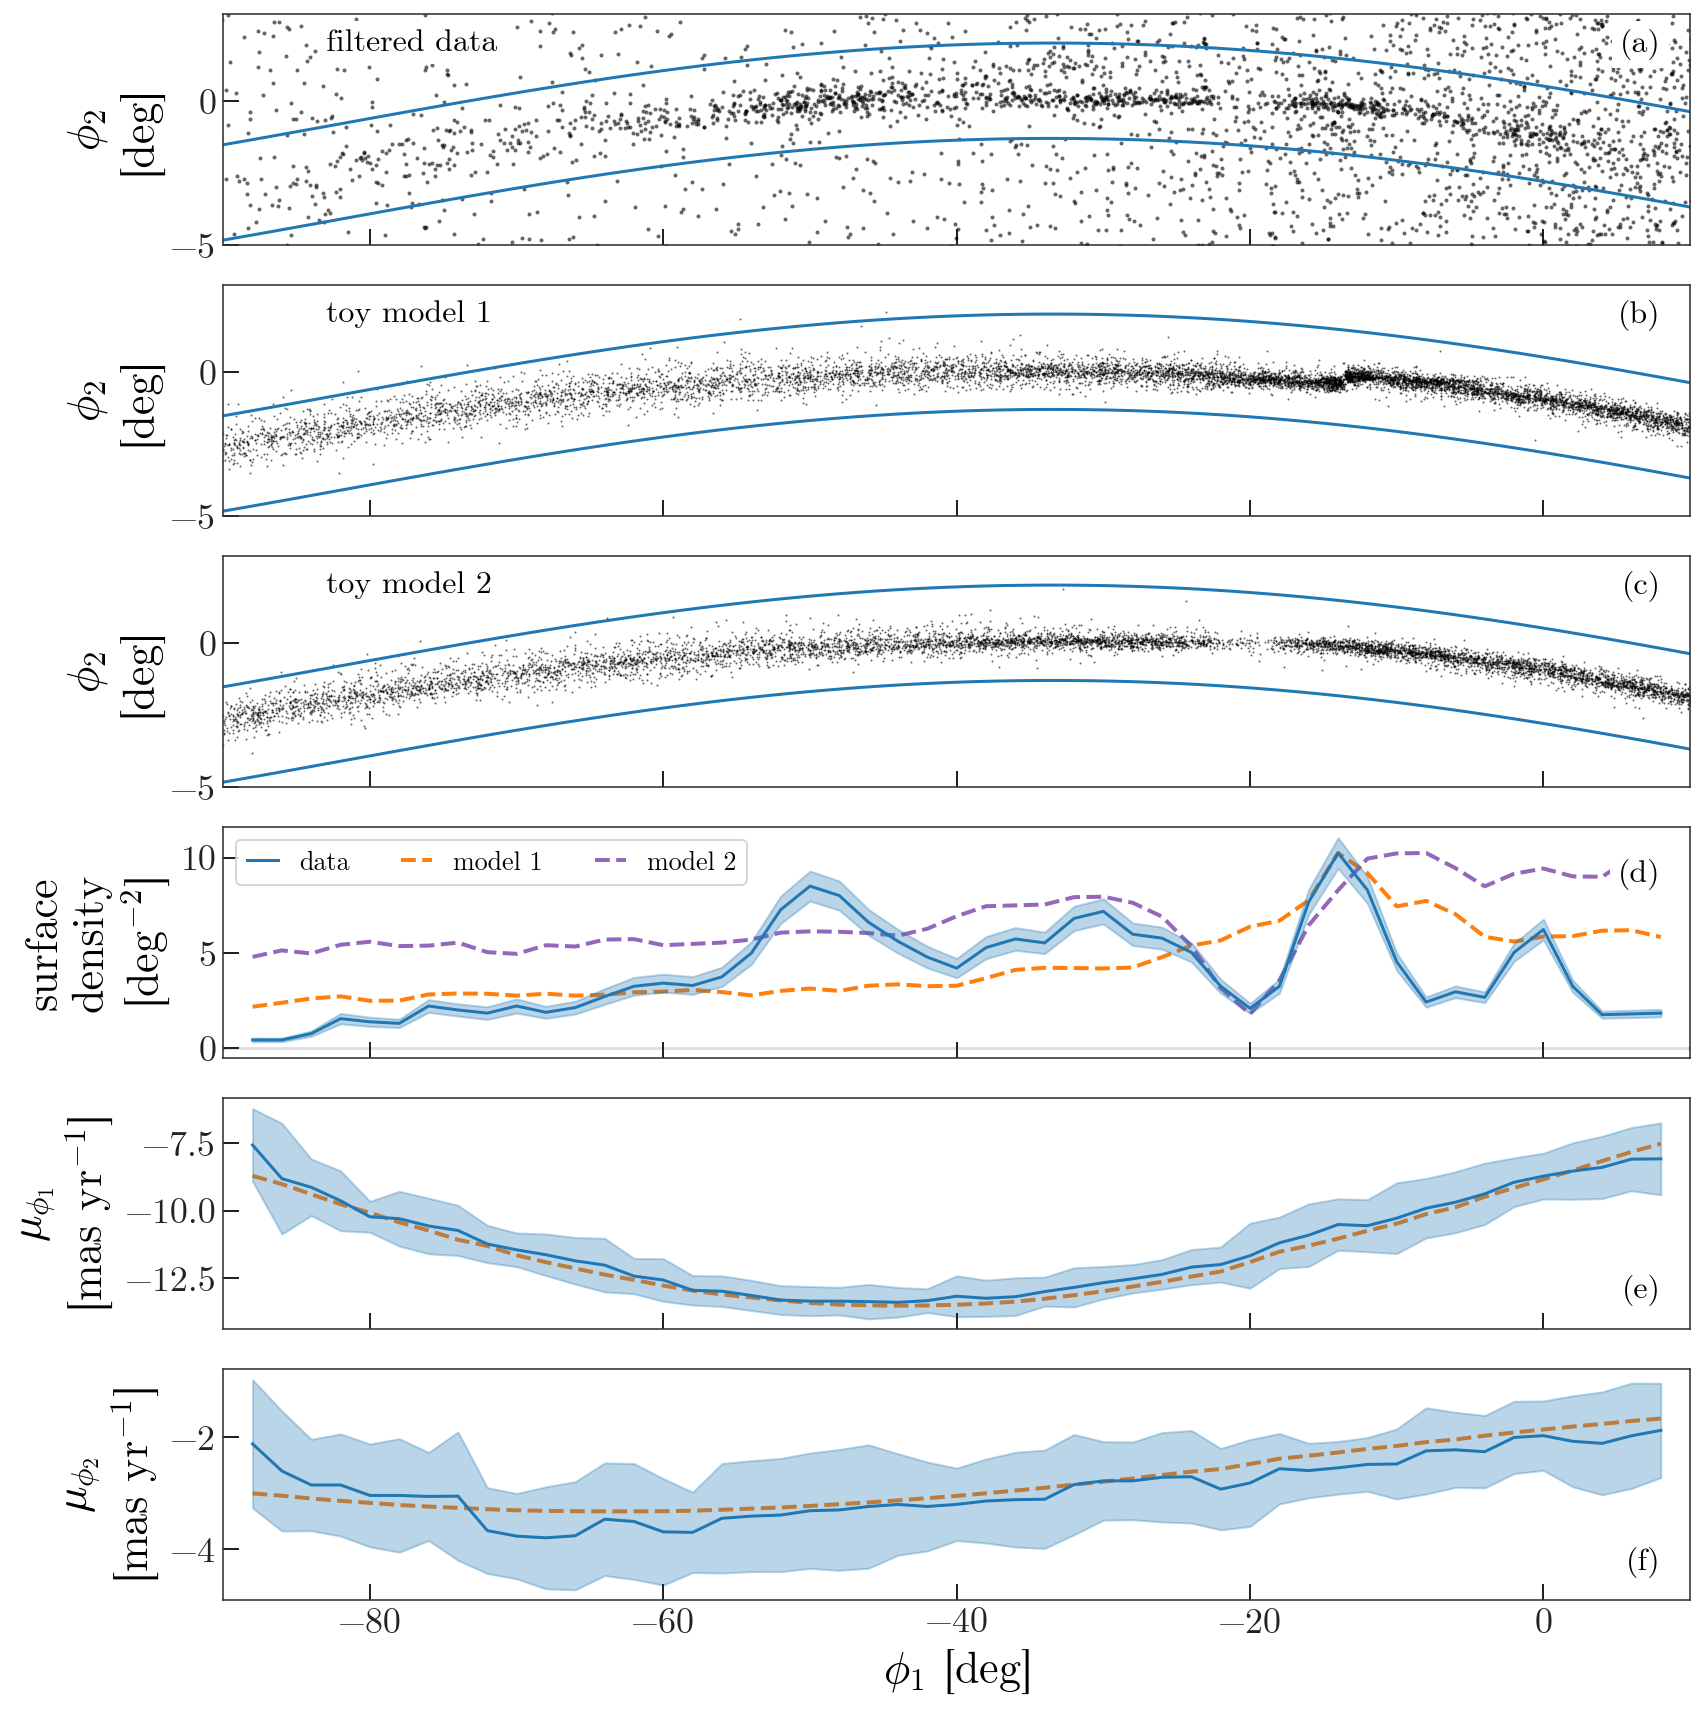

In [29]:
fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

ax = axes[0]
ax.plot(phi1, phi2, **ptstyle)

ax.plot(phi1_, phi2_+phi2_plus, '-', color='tab:blue')
ax.plot(phi1_, phi2_-phi2_minus, '-', color='tab:blue')
ax.text(-83, 2.5, 'filtered data', ha='left', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)
ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-5, 3)

ax.text(8, 2.5, '(a)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

# phi2 track:
# ax = axes[1]
# ax.plot(bins_phi1, rmed_phi2, '-')
# ax.fill_between(bins_phi1, rmed_phi2-w, rmed_phi2+w, 
#                 color='tab:blue', alpha=0.3)

# ax.plot(bins_phi1, model_rmed_phi2, '--', color='tab:orange', zorder=-10, lw=2)

# ax.set_ylabel('$\phi_2$\n[deg]')

# model stream
for j, ax in enumerate([axes[1], axes[2]]):
    ax.plot(streams[j].phi1.wrap_at(180*u.deg), 
            streams[j].phi2, 
            marker='o', linestyle='none', ms=1., color='k', 
            alpha=0.6, rasterized=True)

    ax.plot(phi1_, phi2_+phi2_plus, '-', color='tab:blue')
    ax.plot(phi1_, phi2_-phi2_minus, '-', color='tab:blue')
    ax.text(-83, 2.5, 'toy model {0}'.format(j+1), ha='left', va='top', 
            bbox=dict(facecolor='w', alpha=1), fontsize=16)

    ax.set_ylabel('$\phi_2$\n[deg]')
    ax.set_ylim(-5, 3)
    
axes[1].text(8, 2.5, '(b)', ha='right', va='top', 
             bbox=dict(facecolor='w', alpha=1), fontsize=16)
axes[2].text(8, 2.5, '(c)', ha='right', va='top', 
             bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[3]
ax.plot(track['phi1'], track['density'], '-', label='data')
ax.fill_between(track['phi1'], 
                track['density']*(1-1/np.sqrt(track['n'])), 
                track['density']*(1+1/np.sqrt(track['n'])), 
                color='tab:blue', alpha=0.3)
ax.axhline(0, zorder=-10, alpha=0.2)

ax.plot(track['phi1'], model_densitys[0], '--', 
        color='tab:orange', zorder=-10, lw=2, label='model 1')
ax.plot(track['phi1'], model_densitys[1], '--', 
        color='tab:purple', zorder=-10, lw=2, label='model 2')
ax.legend(loc='upper left', fontsize=13, ncol=3, handlelength=1.2)

ax.set_ylabel('surface\ndensity\n[deg$^{-2}$]')

ax.text(8, 10, '(d)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[4]
ax.plot(track['phi1'], track['pm_phi1_cosphi2'], '-')
ax.fill_between(track['phi1'], 
                track['pm_phi1_cosphi2']-track['pm_phi1_cosphi2_error'], 
                track['pm_phi1_cosphi2']+track['pm_phi1_cosphi2_error'], 
                color='tab:blue', alpha=0.3)

ax.plot(track['phi1'], model_rmed_pmphi1, '--', 
        color='tab:orange', zorder=-10, lw=2)

ax.set_ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

ax.text(8, -13.5, '(e)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[5]
ax.plot(track['phi1'], track['pm_phi2'], '-')
ax.fill_between(track['phi1'], 
                track['pm_phi2'] - track['pm_phi2_error'], 
                track['pm_phi2'] + track['pm_phi2_error'], 
                color='tab:blue', alpha=0.3)

ax.plot(track['phi1'], model_rmed_pmphi2, '--', color='tab:orange', zorder=-10, lw=2)

ax.set_xlabel('$\phi_1$ [deg]')
ax.set_ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

ax.text(8, -4.5, '(f)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

axes[0].set_xlim(-90, 10)

fig.set_facecolor('w')
fig.tight_layout()
fig.savefig('../paper/track_observables.pdf', dpi=250)